## Adversarial Variational Bayes ##
- https://arxiv.org/pdf/1701.04722.pdf
- Use adversarial training along with a more flexible inference model 
- Reformulates VAE so that the noise is input into the model along with data
- This allows model to learn arbitrary probability distributions in the latent space (unlike imposing a Gaussian for traditional VAEs)
- They also introduce a discriminator which takes pairs of data and latent representation and tries to distinguish actual pairs from the data and generated pairs from the current model
- The new optimization objective aims to maximize (over inference and generative parameters) the log probability of observing the data, $x$, given the learned latent representation, $z$, minus the discriminator, $T$'s, ability to tell that the pair $x, z$ were generated

$$\max_{\theta,\phi} \mathbf{E}_{p_{D}(x)}\mathbf{E}_{\epsilon}\left(-T^*(x, z_\phi(x, \epsilon)) + \text{log} p_\theta(x \mid z_\phi(x, \epsilon) ) \right) $$

- $z_\phi$ is the inference model
- $\epsilon$ is Gaussian noise
- $p_\theta$ is the generative model
- $T^*$ is the optimal discriminator

In [197]:
import tensorflow as tf
from tensorflow.contrib.distributions import MultivariateNormalDiag
from tensorflow.contrib.bayesflow import stochastic_tensor
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.python.debug.lib import debug_utils
from tqdm import tqdm_notebook, tnrange
np.set_printoptions(precision=3)
np.random.seed(18181)

%matplotlib inline

import plotly.plotly as py
import plotly.graph_objs as go

import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

import tensorflow.contrib.slim as slim

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7800313022673723709, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 498335744
 locality {
   bus_id: 2
 }
 incarnation: 10019821672067970362
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:82:00.0"]

In [198]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [263]:
tf.reset_default_graph()

original_dim = [28, 28, 1]
latent_dim = 2
batch_size = 1000
clipNorm = 0.01
M = 5 # number of noise vectors
lr = 10**-4 # Learning Rate
epochs = 2500

noise_dims = [64, 32, latent_dim]
a_phi_dims = [128, 64, 32]
theta_dims = [4096, 4096, 2048, 2048, 1024]
psi_dims = [1024, 512, 16]

x = tf.placeholder(tf.float32, [batch_size] + original_dim, name='x')
z = tf.random_normal([batch_size, latent_dim], dtype=tf.float32, name="z")

## Adaptive Contrast ##
- Using "Adaptive Contrast" from the paper
    - Allows us to compare the current inference model to an adaptive distribution instead of the prior $p(z)$
    - Estimate moments of inference model
    - Generate $m$ noise vectors ($\epsilon$)
    - Each noise vector is passed through a small NN producing a vector with same dimensionality as latent space ... $v_{i,k}(\epsilon)$
    - Another set of NNs are used to estimate $m$ coefficients from the input $x$ .... $a_i(x)$
    - The latent space representation is a linear combination of the learned noise vectors using these coefficients
    
    $$z_k = \sum_{i=1}^m v_{i,k}(\epsilon_i )a_{i,k}(x)$$

In [264]:
# Adaptive distribution r_alpha(z | x)
# Generate noise vector nets
noise_basis = []

for i in range(M):
    phi_noise = slim.stack(tf.random_normal([batch_size, latent_dim], dtype=tf.float32), 
                           slim.fully_connected, 
                           noise_dims, 
                           scope="phi_noise_basis_pre_{}".format(i))
    
    noise_basis.append(slim.fully_connected(phi_noise, 
                                            latent_dim, 
                                            activation_fn=None, 
                                            scope="phi_noise_basis_pre_{}".format(i)))
    
v_basis = tf.stack(noise_basis, axis=1, name="v_basis")  

a_phi_pre_conv = slim.conv2d(x, 256, [16, 16], scope="phi_a_pre_conv1")
a_phi_pre_conv = slim.max_pool2d(a_phi_pre_conv, [16, 16], scope="phi_a_pre_conv_maxpool1")
a_phi_pre_conv = slim.flatten(a_phi_pre_conv, scope="phi_a_pre_conv_flatten")
a_phi_pre = slim.stack(a_phi_pre_conv, slim.fully_connected, a_phi_dims, scope="phi_a_pre")

a_phis = tf.expand_dims(slim.fully_connected(a_phi_pre, 
                                             M, 
                                             activation_fn=None, 
                                             scope="phi_a"), axis=1)


## Inference ##
- Creates a latent representation of data

$$q_\phi\left( z \mid x\right)$$

- Using the reparameratization trick from Kingma and Welling...

$$z_\phi(x, \epsilon)$$

- Moments of each $z$ are

$$ \mathbf{E}(z_k) = \sum_{i=1}^{m}\mathbf{E}[v_{i,k}(\epsilon_i)]a_{i,k}(x)$$

$$ \mathbf{Var}(z_k) = \sum_{i=1}^{m}\mathbf{Var}[v_{i,k}(\epsilon_i)]a_{i,k}(x)^2$$

In [265]:
# Inference model - q_phi(z | x)
# Linear combination of the noise basis vectors from above
z_phi = tf.squeeze(tf.matmul(a_phis, v_basis), axis=1, name="z_phi") 

# Moments estimated from minibatch - for each noise basis vector
alpha_mini_mu = tf.reduce_mean(v_basis, axis=0, name="alpha_mini_mu")
alpha_mini_sigma = tf.reduce_mean( (v_basis - alpha_mini_mu)**2 , axis=0, name="alpha_mini_sigma")

# Estimate moments of current inference model for x
alpha_mu_x = tf.reduce_sum(alpha_mini_mu * tf.transpose(a_phis, perm=[0,2,1]), axis=1, name="alpha_mu_x")
alpha_sigma_x = tf.reduce_sum(alpha_mini_sigma * tf.transpose(a_phis, perm=[0,2,1])**2, axis=1, name="alpha_sigma_x")

# Z-score transform it
z_hat = tf.identity((z_phi - alpha_mu_x) / alpha_sigma_x, name="z_hat_phi")

## Generative ##
- Reconstruct original from latent space representation
$$p_\theta(x \mid z) $$

In [266]:
theta_x_gen_pre = slim.stack(z_phi, 
                             slim.fully_connected, 
                             theta_dims,
                             scope="theta_x_gen_pre")

theta_x_gen = tf.reshape(slim.fully_connected(theta_x_gen_pre, 
                                   np.prod(original_dim),
                                   activation_fn=tf.sigmoid, 
                                   scope="theta_x_gen"), [batch_size] + original_dim)

## Discriminator ##
- Tries to distinguish generated from real pairs of $x$ and $z$
- $\text{z_hat}$ is the Z-score transformed version of $z$ generated by the inference model
- That way, the discriminator just compares this to the multivariate Gaussian

In [267]:
# Output on generated samples
T_psi_generated_pre_conv = slim.conv2d(x, 128, [16, 16], scope="T_psi_pre_conv1")
T_psi_generated_pre_conv = slim.max_pool2d(T_psi_generated_pre_conv, [8, 8], scope="T_psi_pre_conv_maxpool1")
T_psi_generated_pre_conv = slim.flatten(T_psi_generated_pre_conv, scope="T_psi_pre_conv_flatten")

T_psi_generated_pre = slim.stack(tf.concat([T_psi_generated_pre_conv, z_hat], axis=1), 
                                 slim.fully_connected, 
                                 psi_dims,
                                 scope="T_psi_pre")

T_psi_generated = slim.fully_connected(T_psi_generated_pre, 
                                       1, 
                                       activation_fn=None, 
                                       scope="T_psi")

# Output on real samples
T_psi_real_pre_conv = slim.conv2d(x, 128, [16, 16], reuse=True, scope="T_psi_pre_conv1")
T_psi_real_pre_conv = slim.max_pool2d(T_psi_real_pre_conv, [8, 8], scope="T_psi_pre_conv_maxpool1")
T_psi_real_pre_conv = slim.flatten(T_psi_real_pre_conv, scope="T_psi_pre_conv_flatten")

T_psi_real_pre = slim.stack(tf.concat([T_psi_real_pre_conv, z_hat], axis=1), 
                                 slim.fully_connected, 
                                 psi_dims,
                                 reuse=True,
                                 scope="T_psi_pre")

T_psi_real = slim.fully_connected(T_psi_real_pre, 
                                       1, 
                                       reuse=True,
                                       activation_fn=None, 
                                       scope="T_psi")

## Losses and Optimizer ##
- These are negated from the paper so we can apply gradient descent
- $p(x\mid z)$
- We use reconstruction error to estimate

In [268]:
loss_theta = tf.reduce_sum(tf.square(slim.flatten(x) - slim.flatten(theta_x_gen)), axis=1)
loss_phi = T_psi_generated + loss_theta 

loss_psi = tf.log(tf.sigmoid(T_psi_generated) + 10**-5) + tf.log(1 - tf.sigmoid(T_psi_real) + 10**-5) 

In [269]:
def compute_apply_grad(loss, keyword=None, learn_rate=0.001, clip_norm=0.01, **kwargs):
    """ Computes the gradients of variables matching keyword. Returns an optimizer"""
    opt = tf.train.AdamOptimizer(learning_rate=learn_rate, **kwargs)
    if keyword is None:
        cur_vars = [v for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)]
    else:
        cur_vars = [v for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if keyword in v.name]
    g = opt.compute_gradients(loss, cur_vars)
    g = [(tf.clip_by_norm(gr, clip_norm), v) for gr, v in g]
    optimize = opt.apply_gradients(g)
    return optimize

In [270]:
opt_theta = compute_apply_grad(loss_theta, learn_rate=lr, clip_norm=clipNorm, keyword="theta", epsilon=10**-4)
opt_phi = compute_apply_grad(loss_phi, learn_rate=lr, clip_norm=clipNorm, keyword="phi", epsilon=10**-4)
opt_psi = compute_apply_grad(loss_psi, learn_rate=lr, clip_norm=clipNorm, keyword="psi", epsilon=10**-4)

## Training ##

In [271]:
avg_theta = tf.reduce_mean(loss_theta) # Over batch
avg_phi = tf.reduce_mean(loss_phi) 
avg_psi = tf.reduce_mean(loss_psi)

In [272]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [273]:
train_all = [opt_theta, opt_phi, opt_psi, avg_theta, avg_phi, avg_psi]
train_discriminator = [opt_psi, avg_theta, avg_phi, avg_psi]

In [295]:
# = trange(mnist.train.num_examples // batch_size)
perf = {'Theta': None, 'Phi': None, 'Psi': None}

for e in tnrange(epochs, desc='Overall Training', unit='epoch'):
    bperf = {'Theta': [], 'Phi': [], 'Psi': []}
    for i in tnrange(mnist.train.num_examples // batch_size, postfix=perf, unit=' batches', desc="Epoch {}".format(e+1)):
        batch = np.reshape(mnist.train.next_batch(batch_size)[0], (batch_size, 28, 28, 1))
        if i % 2 == 1:
            # Train the inference and generative nets every other batch
            _, _, _, at, ap, aps = sess.run(train_all, feed_dict={x: batch}) 
        else:
            # Train the discriminator every epoch (try to get T closer to T* - the optimal T)
            _, at, ap, aps = sess.run(train_discriminator, feed_dict={x: batch})    
            
        bperf['Theta'].append(at)
        bperf['Phi'].append(ap)
        bperf['Psi'].append(aps)
    
    perf['Theta'] = np.mean(bperf['Theta'])
    perf['Phi'] = np.mean(bperf['Phi'])
    perf['Psi'] = np.mean(bperf['Psi'])
        

KeyboardInterrupt: 

In [297]:
saver = tf.train.Saver()
#saver.restore(sess, "data/model.ckpt")
save_path = saver.save(sess, "data/model.ckpt")

In [288]:
# Predict on some training data
test_batch = mnist.test.next_batch(batch_size)
pred_z, pred_x, pred_a, pred_t = sess.run([z_phi, theta_x_gen, a_phis, theta_x_gen_pre], 
                                          feed_dict={x: np.reshape(test_batch[0], (batch_size, 28, 28, 1))})

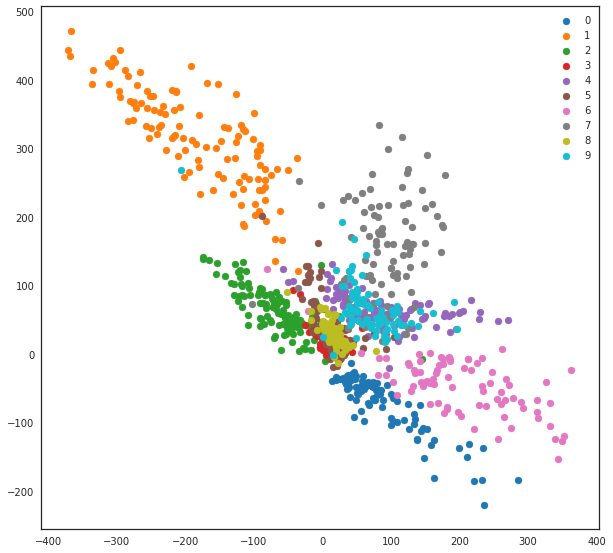

In [290]:
f, ax = plt.subplots(figsize=(10, 10))
plt.axes().set_aspect('equal')
#plt.xlim((-0.01, 0.01))
#plt.ylim((-0.01, 0.01))
colors = plt.cm.Vega10(np.linspace(0, 1, 10))
for i, c in enumerate(colors):
    n_ix = np.where(test_batch[1] == i)
    plt.scatter(pred_z[n_ix, 0], pred_z[n_ix, 1], label=i, color=c)
l = plt.legend()

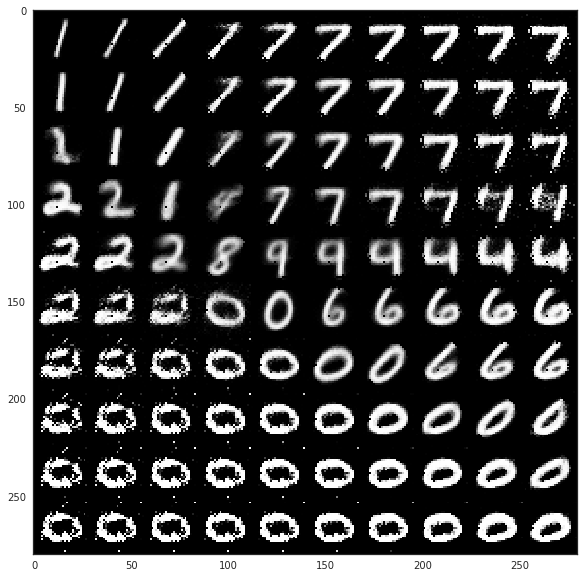

In [294]:
# Generate some samples from low dim latent space
# display a 2D manifold of the digits
# https://blog.keras.io/building-autoencoders-in-keras.html

n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(400, -400, n)
grid_y = np.linspace(-200, 400, n)

#horrible inefficient
samps = np.zeros((batch_size, 2))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        samps[0, :] = [xi, yi]
        x_decoded = 1 - sess.run(theta_x_gen, feed_dict={z_phi: samps})
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()